In [1]:
#Create a folder called celeba in home dir where reconstructed images will be stored
#Considered only 100000 images for training

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as utils
import gc
import pywt
import IPython
import random
from random import sample

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
no_of_sample = 1
CUDA = True
BATCH_SIZE = 32
LOG_INTERVAL = 5
h_img = 128
w_img = 128
flat = h_img*w_img*3
train_losses = []

In [2]:
w=pywt.Wavelet('bior2.2')


dec_hi = torch.Tensor(w.dec_hi[::-1]).cuda() 
dec_lo = torch.Tensor(w.dec_lo[::-1]).cuda()
rec_hi = torch.Tensor(w.rec_hi).cuda()
rec_lo = torch.Tensor(w.rec_lo).cuda()
dec_hi_cpu = torch.Tensor(w.dec_hi[::-1]).clone().cpu()
dec_lo_cpu = torch.Tensor(w.dec_lo[::-1]).clone().cpu()
rec_hi_cpu = torch.Tensor(w.rec_hi).clone().cpu()
rec_lo_cpu = torch.Tensor(w.rec_lo).clone().cpu()


filters = torch.stack([dec_lo_cpu.unsqueeze(0)*dec_lo_cpu.unsqueeze(1),
                       dec_lo_cpu.unsqueeze(0)*dec_hi_cpu.unsqueeze(1),
                       dec_hi_cpu.unsqueeze(0)*dec_lo_cpu.unsqueeze(1),
                       dec_hi_cpu.unsqueeze(0)*dec_hi_cpu.unsqueeze(1)], dim=0)

inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)


def wt(vimg, levels=1):
    h = vimg.size(2)
    w = vimg.size(3)
#     print(vimg.size())
    padded = torch.nn.functional.pad(vimg,(2,2,2,2))
    res = torch.nn.functional.conv2d(padded, Variable(filters[:,None]),stride=2)
    if levels>1:
        res[:,:1] = wt(res[:,:1],levels-1)
        res[:,:1,32:,:] = res[:,:1,32:,:]*1.
        res[:,:1,:,32:] = res[:,:1,:,32:]*1.
        res[:,1:] = res[:,1:]*1.
    res = res.view(-1,2,h//2,w//2).transpose(1,2).contiguous().view(-1,1,h,w)
    return res



def iwt(vres, levels=1):
    h = vres.size(2)
    w = vres.size(3)
    res = vres.contiguous().view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
    if levels>1:
        res[:,:1] = iwt(res[:,:1], levels=levels-1)
    res = torch.nn.functional.conv_transpose2d(res, Variable(inv_filters[:,None]),stride=2)
    res = res[:,:,2:-2,2:-2] #removing padding
#     print(res.shape)
    return res

In [3]:
class CelebaDataset(Dataset):

    def __init__(self, root_dir, img_list, WT=False):
        self.root_dir = root_dir
        self.img_list = img_list
        self.WT = WT

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_dir, self.img_list[idx]))
        img = np.array(img)
        img = img / 255
        img = torch.from_numpy(img.transpose(2,0,1)).float()
        
        # Returning both original image and WT image if self.WT
        if self.WT:
#             img_wt = torch.from_numpy(img.transpose(2,0,1)).float()
            img_wt = wt(img_wt.unsqueeze(1)).squeeze()

            return img, img_wt
        
        return img
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors. numpy image: H x W x C, torch image: C X H X W
    """

    def __call__(self, image, invert_arrays=True):

        if invert_arrays:
            image = image.transpose((2, 0, 1))[:,:h_img*2,:w_img*2]

        return torch.from_numpy(image)

2445

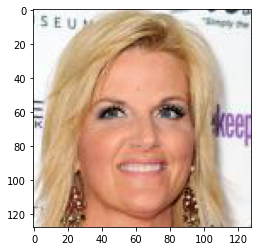

In [6]:
# Creating and testing dataset with WT & IWT
random.seed(2020)
root_dir = "/disk_c/han/celeba128/"
image_files = os.listdir(root_dir)

ds = CelebaDataset('/disk_c/han/celeba128/', image_files, WT=False)
ds_loader = DataLoader(ds, batch_size=1, num_workers=10, shuffle=True)

# Show original img
t = ds[0]
plt.imshow(t.numpy().transpose((1,2,0)))

gc.collect()


In [7]:
print(len(image_files))

30000


In [13]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(nn.Module):
    def forward(self, input, size=2048):
        return input.view(input.size(0), size, 1, 1)

class UnFlatten1(nn.Module):        
    def forward(self, input, size=512):
        return input.view(input.size(0), size, 2, 2)


class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=2048, z_dim=100):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2), # N * 32 * 63 * 63
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # N * 64 * 30 * 30,
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2), # N * 128 * 14 * 14
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2), # N * 256 * 6 * 6
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2), # N * 512 * 2 * 2
            nn.BatchNorm2d(512),
            nn.ReLU(),
            Flatten()
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        # Decoder
        self.fct_decode_1 = nn.Sequential(
            UnFlatten1(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2), # N * 256 * 6 * 6
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2), # N * 128 * 14 * 14
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2), # N * 64 * 30 * 30
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2), # N * 64 * 62 * 62
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=2, output_padding=1), # N * 3 * 128 * 128
            nn.Sigmoid(),
        )
        
        self.wt1 = nn.Sequential(
            nn.Conv2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2), # N * 3 * 128 * 128
            nn.BatchNorm2d(image_channels)
        )
        
        self.wt2 = nn.Sequential(
            nn.Conv2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2), # N * 3 * 128 * 128
            nn.BatchNorm2d(image_channels)
        )
        
#         self.wt3 = nn.Sequential(
#             nn.Conv2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2), # N * 3 * 64 * 64
#             nn.BatchNorm2d(image_channels)
#         )
        

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            # return torch.normal(mu, std)
            esp = torch.randn(*mu.size()).cuda()
            z = mu + std * esp
            return z
        else:
            return mu
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.fct_decode_1(z)
        z = self.wt1(z)
        z = self.wt2(z)
#         z = self.wt3(z)
        
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
       
#         z_final = Variable(torch.stack([z_1,z_2,z_3,z_4], dim=1))
#         z_final = z_final.view(-1,2,128//2,128//2).transpose(1,2).contiguous().view(-1,1,128,128)

    def loss_function(self, wt_x, x, mu, logvar) -> Variable:
        
        wt_x = wt_x.view(-1,1,128,128)
        x_recon = iwt(wt_x, levels=2)
        x_recon = x_recon.view(-1,3,128,128)
        x_recon = x_recon.contiguous()
        
        # Loss btw reconstructed img and original img
        BCE = F.l1_loss(x_recon.view(-1, 3 * 128 * 128), x.view(-1, 3 * 128 * 128))

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.0001
        KLD /= BATCH_SIZE * 3 * 128 * 128

        return BCE + KLD

In [9]:

def train(epoch, model, optimizer, train_loader):
    # toggle model to train mode
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        
        if CUDA:
            data = data.cuda()

        optimizer.zero_grad()
        
        wt_batch, mu, logvar = model(data)
        loss = model.loss_function(wt_batch, data, mu, logvar)
        loss.backward()
        
        train_losses.append(loss.item())
        train_loss += loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss / len(data)))
            
            n = min(data.size(0), 8)
           

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))




In [10]:
# Training on only 10,000 images
random.seed(2020)
image_files = random.sample(image_files, 10000)
train_dataset = CelebaDataset('/disk_c/han/celeba128/', image_files, WT=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=10, shuffle=True)

In [15]:
# train_losses = []
# gc.collect()
# EPOCHS = 100
# model = VAE()
# if CUDA: 
#     print('CUDA = {}'.format(CUDA))
#     model.cuda()
# #     x_sample = torch.randn(32,3,64,64).cuda()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# os.mkdir('/disk_c/han/image_samples/celeba_wtvae128/')
# os.mkdir('/disk_c/han/models/wtvae128_models/')

# for epoch in range(1, EPOCHS + 1):
#     train(epoch, model, optimizer, train_loader)

#     # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
#     # digits in latent space
#     sample = Variable(torch.randn(32,100))
#     if CUDA:
#         sample = sample.cuda()
#     x_sample1 = model.decode(sample)
#     save_image(x_sample1[:8].cpu(), '/disk_c/han/image_samples/celeba_wtvae128/decoded_sample' + str(epoch) + '.png')  
    
#     x_sample1 = x_sample1.view(-1,1,128,128)
#     x_sample1 = iwt(x_sample1, levels=2)
#     x_sample1 = x_sample1.view(-1,3,128,128)
# #     x_sample1 /= torch.max(x_sample1)
    
#     x_sample1 = x_sample1.contiguous()
#     save_image(x_sample1[:8].cpu(), '/disk_c/han/image_samples/celeba_wtvae128/sample' + str(epoch) + '.png')  
    
#     torch.save(model.state_dict(), '/disk_c/han/models/wtvae128_models/wtvae_epoch{}.pth'.format(epoch))
    

    

CUDA = True
Train Epoch: 1 [0/10000 (0%)]	Loss: 0.030173
Train Epoch: 1 [160/10000 (2%)]	Loss: 0.018463
Train Epoch: 1 [320/10000 (3%)]	Loss: 0.017377
Train Epoch: 1 [480/10000 (5%)]	Loss: 0.015539
Train Epoch: 1 [640/10000 (6%)]	Loss: 0.013226
Train Epoch: 1 [800/10000 (8%)]	Loss: 0.011821
Train Epoch: 1 [960/10000 (10%)]	Loss: 0.010885
Train Epoch: 1 [1120/10000 (11%)]	Loss: 0.010042
Train Epoch: 1 [1280/10000 (13%)]	Loss: 0.010387
Train Epoch: 1 [1440/10000 (14%)]	Loss: 0.010360
Train Epoch: 1 [1600/10000 (16%)]	Loss: 0.009490
Train Epoch: 1 [1760/10000 (18%)]	Loss: 0.008855
Train Epoch: 1 [1920/10000 (19%)]	Loss: 0.009081
Train Epoch: 1 [2080/10000 (21%)]	Loss: 0.008401
Train Epoch: 1 [2240/10000 (22%)]	Loss: 0.008331
Train Epoch: 1 [2400/10000 (24%)]	Loss: 0.008950
Train Epoch: 1 [2560/10000 (26%)]	Loss: 0.008137
Train Epoch: 1 [2720/10000 (27%)]	Loss: 0.009459
Train Epoch: 1 [2880/10000 (29%)]	Loss: 0.008316
Train Epoch: 1 [3040/10000 (30%)]	Loss: 0.008324
Train Epoch: 1 [3200/10

Train Epoch: 3 [6560/10000 (65%)]	Loss: 0.004058
Train Epoch: 3 [6720/10000 (67%)]	Loss: 0.004526
Train Epoch: 3 [6880/10000 (69%)]	Loss: 0.004641
Train Epoch: 3 [7040/10000 (70%)]	Loss: 0.004421
Train Epoch: 3 [7200/10000 (72%)]	Loss: 0.004107
Train Epoch: 3 [7360/10000 (73%)]	Loss: 0.004207
Train Epoch: 3 [7520/10000 (75%)]	Loss: 0.004460
Train Epoch: 3 [7680/10000 (77%)]	Loss: 0.004321
Train Epoch: 3 [7840/10000 (78%)]	Loss: 0.004276
Train Epoch: 3 [8000/10000 (80%)]	Loss: 0.004203
Train Epoch: 3 [8160/10000 (81%)]	Loss: 0.004263
Train Epoch: 3 [8320/10000 (83%)]	Loss: 0.004113
Train Epoch: 3 [8480/10000 (85%)]	Loss: 0.003995
Train Epoch: 3 [8640/10000 (86%)]	Loss: 0.004353
Train Epoch: 3 [8800/10000 (88%)]	Loss: 0.004132
Train Epoch: 3 [8960/10000 (89%)]	Loss: 0.004162
Train Epoch: 3 [9120/10000 (91%)]	Loss: 0.003996
Train Epoch: 3 [9280/10000 (93%)]	Loss: 0.004108
Train Epoch: 3 [9440/10000 (94%)]	Loss: 0.004090
Train Epoch: 3 [9600/10000 (96%)]	Loss: 0.004290
Train Epoch: 3 [9760

Train Epoch: 6 [2880/10000 (29%)]	Loss: 0.003619
Train Epoch: 6 [3040/10000 (30%)]	Loss: 0.003590
Train Epoch: 6 [3200/10000 (32%)]	Loss: 0.003806
Train Epoch: 6 [3360/10000 (34%)]	Loss: 0.003750
Train Epoch: 6 [3520/10000 (35%)]	Loss: 0.003751
Train Epoch: 6 [3680/10000 (37%)]	Loss: 0.003301
Train Epoch: 6 [3840/10000 (38%)]	Loss: 0.003695
Train Epoch: 6 [4000/10000 (40%)]	Loss: 0.003902
Train Epoch: 6 [4160/10000 (42%)]	Loss: 0.003521
Train Epoch: 6 [4320/10000 (43%)]	Loss: 0.003946
Train Epoch: 6 [4480/10000 (45%)]	Loss: 0.003508
Train Epoch: 6 [4640/10000 (46%)]	Loss: 0.003771
Train Epoch: 6 [4800/10000 (48%)]	Loss: 0.003879
Train Epoch: 6 [4960/10000 (50%)]	Loss: 0.003730
Train Epoch: 6 [5120/10000 (51%)]	Loss: 0.003947
Train Epoch: 6 [5280/10000 (53%)]	Loss: 0.003440
Train Epoch: 6 [5440/10000 (54%)]	Loss: 0.003814
Train Epoch: 6 [5600/10000 (56%)]	Loss: 0.003780
Train Epoch: 6 [5760/10000 (58%)]	Loss: 0.003668
Train Epoch: 6 [5920/10000 (59%)]	Loss: 0.003656
Train Epoch: 6 [6080

Train Epoch: 8 [9440/10000 (94%)]	Loss: 0.003509
Train Epoch: 8 [9600/10000 (96%)]	Loss: 0.003719
Train Epoch: 8 [9760/10000 (97%)]	Loss: 0.003473
Train Epoch: 8 [9920/10000 (99%)]	Loss: 0.003919
====> Epoch: 8 Average loss: 0.0035
Train Epoch: 9 [0/10000 (0%)]	Loss: 0.003627
Train Epoch: 9 [160/10000 (2%)]	Loss: 0.003276
Train Epoch: 9 [320/10000 (3%)]	Loss: 0.003250
Train Epoch: 9 [480/10000 (5%)]	Loss: 0.003436
Train Epoch: 9 [640/10000 (6%)]	Loss: 0.003586
Train Epoch: 9 [800/10000 (8%)]	Loss: 0.003741
Train Epoch: 9 [960/10000 (10%)]	Loss: 0.003365
Train Epoch: 9 [1120/10000 (11%)]	Loss: 0.003677
Train Epoch: 9 [1280/10000 (13%)]	Loss: 0.003512
Train Epoch: 9 [1440/10000 (14%)]	Loss: 0.003712
Train Epoch: 9 [1600/10000 (16%)]	Loss: 0.003313
Train Epoch: 9 [1760/10000 (18%)]	Loss: 0.003428
Train Epoch: 9 [1920/10000 (19%)]	Loss: 0.003561
Train Epoch: 9 [2080/10000 (21%)]	Loss: 0.003554
Train Epoch: 9 [2240/10000 (22%)]	Loss: 0.003635
Train Epoch: 9 [2400/10000 (24%)]	Loss: 0.003382

Train Epoch: 11 [5440/10000 (54%)]	Loss: 0.003273
Train Epoch: 11 [5600/10000 (56%)]	Loss: 0.003130
Train Epoch: 11 [5760/10000 (58%)]	Loss: 0.003280
Train Epoch: 11 [5920/10000 (59%)]	Loss: 0.003372
Train Epoch: 11 [6080/10000 (61%)]	Loss: 0.003007
Train Epoch: 11 [6240/10000 (62%)]	Loss: 0.003318
Train Epoch: 11 [6400/10000 (64%)]	Loss: 0.003221
Train Epoch: 11 [6560/10000 (65%)]	Loss: 0.003286
Train Epoch: 11 [6720/10000 (67%)]	Loss: 0.003195
Train Epoch: 11 [6880/10000 (69%)]	Loss: 0.003275
Train Epoch: 11 [7040/10000 (70%)]	Loss: 0.003425
Train Epoch: 11 [7200/10000 (72%)]	Loss: 0.003248
Train Epoch: 11 [7360/10000 (73%)]	Loss: 0.003372
Train Epoch: 11 [7520/10000 (75%)]	Loss: 0.003303
Train Epoch: 11 [7680/10000 (77%)]	Loss: 0.003387
Train Epoch: 11 [7840/10000 (78%)]	Loss: 0.003086
Train Epoch: 11 [8000/10000 (80%)]	Loss: 0.003458
Train Epoch: 11 [8160/10000 (81%)]	Loss: 0.003338
Train Epoch: 11 [8320/10000 (83%)]	Loss: 0.003438
Train Epoch: 11 [8480/10000 (85%)]	Loss: 0.003485


Train Epoch: 14 [1280/10000 (13%)]	Loss: 0.003175
Train Epoch: 14 [1440/10000 (14%)]	Loss: 0.003259
Train Epoch: 14 [1600/10000 (16%)]	Loss: 0.003247
Train Epoch: 14 [1760/10000 (18%)]	Loss: 0.003208
Train Epoch: 14 [1920/10000 (19%)]	Loss: 0.003246
Train Epoch: 14 [2080/10000 (21%)]	Loss: 0.003198
Train Epoch: 14 [2240/10000 (22%)]	Loss: 0.003484
Train Epoch: 14 [2400/10000 (24%)]	Loss: 0.003158
Train Epoch: 14 [2560/10000 (26%)]	Loss: 0.003306
Train Epoch: 14 [2720/10000 (27%)]	Loss: 0.003201
Train Epoch: 14 [2880/10000 (29%)]	Loss: 0.003341
Train Epoch: 14 [3040/10000 (30%)]	Loss: 0.003235
Train Epoch: 14 [3200/10000 (32%)]	Loss: 0.002880
Train Epoch: 14 [3360/10000 (34%)]	Loss: 0.003212
Train Epoch: 14 [3520/10000 (35%)]	Loss: 0.003372
Train Epoch: 14 [3680/10000 (37%)]	Loss: 0.003085
Train Epoch: 14 [3840/10000 (38%)]	Loss: 0.003130
Train Epoch: 14 [4000/10000 (40%)]	Loss: 0.002990
Train Epoch: 14 [4160/10000 (42%)]	Loss: 0.003028
Train Epoch: 14 [4320/10000 (43%)]	Loss: 0.003249


Train Epoch: 16 [7200/10000 (72%)]	Loss: 0.003008
Train Epoch: 16 [7360/10000 (73%)]	Loss: 0.003032
Train Epoch: 16 [7520/10000 (75%)]	Loss: 0.003008
Train Epoch: 16 [7680/10000 (77%)]	Loss: 0.003222
Train Epoch: 16 [7840/10000 (78%)]	Loss: 0.003222
Train Epoch: 16 [8000/10000 (80%)]	Loss: 0.003128
Train Epoch: 16 [8160/10000 (81%)]	Loss: 0.003329
Train Epoch: 16 [8320/10000 (83%)]	Loss: 0.003112
Train Epoch: 16 [8480/10000 (85%)]	Loss: 0.003060
Train Epoch: 16 [8640/10000 (86%)]	Loss: 0.003214
Train Epoch: 16 [8800/10000 (88%)]	Loss: 0.002917
Train Epoch: 16 [8960/10000 (89%)]	Loss: 0.003090
Train Epoch: 16 [9120/10000 (91%)]	Loss: 0.003060
Train Epoch: 16 [9280/10000 (93%)]	Loss: 0.003502
Train Epoch: 16 [9440/10000 (94%)]	Loss: 0.003005
Train Epoch: 16 [9600/10000 (96%)]	Loss: 0.003095
Train Epoch: 16 [9760/10000 (97%)]	Loss: 0.003217
Train Epoch: 16 [9920/10000 (99%)]	Loss: 0.003631
====> Epoch: 16 Average loss: 0.0031
Train Epoch: 17 [0/10000 (0%)]	Loss: 0.003114
Train Epoch: 17 [

Train Epoch: 19 [3040/10000 (30%)]	Loss: 0.002968
Train Epoch: 19 [3200/10000 (32%)]	Loss: 0.002996
Train Epoch: 19 [3360/10000 (34%)]	Loss: 0.002994
Train Epoch: 19 [3520/10000 (35%)]	Loss: 0.003070
Train Epoch: 19 [3680/10000 (37%)]	Loss: 0.002893
Train Epoch: 19 [3840/10000 (38%)]	Loss: 0.003097
Train Epoch: 19 [4000/10000 (40%)]	Loss: 0.003030
Train Epoch: 19 [4160/10000 (42%)]	Loss: 0.002913
Train Epoch: 19 [4320/10000 (43%)]	Loss: 0.003027
Train Epoch: 19 [4480/10000 (45%)]	Loss: 0.003015
Train Epoch: 19 [4640/10000 (46%)]	Loss: 0.003066
Train Epoch: 19 [4800/10000 (48%)]	Loss: 0.003354
Train Epoch: 19 [4960/10000 (50%)]	Loss: 0.003051
Train Epoch: 19 [5120/10000 (51%)]	Loss: 0.002953
Train Epoch: 19 [5280/10000 (53%)]	Loss: 0.003042
Train Epoch: 19 [5440/10000 (54%)]	Loss: 0.002930
Train Epoch: 19 [5600/10000 (56%)]	Loss: 0.002966
Train Epoch: 19 [5760/10000 (58%)]	Loss: 0.002962
Train Epoch: 19 [5920/10000 (59%)]	Loss: 0.003056
Train Epoch: 19 [6080/10000 (61%)]	Loss: 0.003021


Train Epoch: 21 [8960/10000 (89%)]	Loss: 0.003072
Train Epoch: 21 [9120/10000 (91%)]	Loss: 0.002972
Train Epoch: 21 [9280/10000 (93%)]	Loss: 0.003010
Train Epoch: 21 [9440/10000 (94%)]	Loss: 0.003021
Train Epoch: 21 [9600/10000 (96%)]	Loss: 0.002870
Train Epoch: 21 [9760/10000 (97%)]	Loss: 0.003150
Train Epoch: 21 [9920/10000 (99%)]	Loss: 0.003053
====> Epoch: 21 Average loss: 0.0030
Train Epoch: 22 [0/10000 (0%)]	Loss: 0.002949
Train Epoch: 22 [160/10000 (2%)]	Loss: 0.002676
Train Epoch: 22 [320/10000 (3%)]	Loss: 0.002798
Train Epoch: 22 [480/10000 (5%)]	Loss: 0.002892
Train Epoch: 22 [640/10000 (6%)]	Loss: 0.003211
Train Epoch: 22 [800/10000 (8%)]	Loss: 0.002850
Train Epoch: 22 [960/10000 (10%)]	Loss: 0.003091
Train Epoch: 22 [1120/10000 (11%)]	Loss: 0.002944
Train Epoch: 22 [1280/10000 (13%)]	Loss: 0.003184
Train Epoch: 22 [1440/10000 (14%)]	Loss: 0.002685
Train Epoch: 22 [1600/10000 (16%)]	Loss: 0.002925
Train Epoch: 22 [1760/10000 (18%)]	Loss: 0.003131
Train Epoch: 22 [1920/10000 

Train Epoch: 24 [4800/10000 (48%)]	Loss: 0.002876
Train Epoch: 24 [4960/10000 (50%)]	Loss: 0.002728
Train Epoch: 24 [5120/10000 (51%)]	Loss: 0.003000
Train Epoch: 24 [5280/10000 (53%)]	Loss: 0.002903
Train Epoch: 24 [5440/10000 (54%)]	Loss: 0.002818
Train Epoch: 24 [5600/10000 (56%)]	Loss: 0.002823
Train Epoch: 24 [5760/10000 (58%)]	Loss: 0.002879
Train Epoch: 24 [5920/10000 (59%)]	Loss: 0.003231
Train Epoch: 24 [6080/10000 (61%)]	Loss: 0.002896
Train Epoch: 24 [6240/10000 (62%)]	Loss: 0.002996
Train Epoch: 24 [6400/10000 (64%)]	Loss: 0.002843
Train Epoch: 24 [6560/10000 (65%)]	Loss: 0.002995
Train Epoch: 24 [6720/10000 (67%)]	Loss: 0.003130
Train Epoch: 24 [6880/10000 (69%)]	Loss: 0.003022
Train Epoch: 24 [7040/10000 (70%)]	Loss: 0.003168
Train Epoch: 24 [7200/10000 (72%)]	Loss: 0.002813
Train Epoch: 24 [7360/10000 (73%)]	Loss: 0.002903
Train Epoch: 24 [7520/10000 (75%)]	Loss: 0.002830
Train Epoch: 24 [7680/10000 (77%)]	Loss: 0.002774
Train Epoch: 24 [7840/10000 (78%)]	Loss: 0.002846


Train Epoch: 27 [640/10000 (6%)]	Loss: 0.003126
Train Epoch: 27 [800/10000 (8%)]	Loss: 0.002866
Train Epoch: 27 [960/10000 (10%)]	Loss: 0.003164
Train Epoch: 27 [1120/10000 (11%)]	Loss: 0.002864
Train Epoch: 27 [1280/10000 (13%)]	Loss: 0.002661
Train Epoch: 27 [1440/10000 (14%)]	Loss: 0.002916
Train Epoch: 27 [1600/10000 (16%)]	Loss: 0.003158
Train Epoch: 27 [1760/10000 (18%)]	Loss: 0.002753
Train Epoch: 27 [1920/10000 (19%)]	Loss: 0.002863
Train Epoch: 27 [2080/10000 (21%)]	Loss: 0.002776
Train Epoch: 27 [2240/10000 (22%)]	Loss: 0.002727
Train Epoch: 27 [2400/10000 (24%)]	Loss: 0.003284
Train Epoch: 27 [2560/10000 (26%)]	Loss: 0.002794
Train Epoch: 27 [2720/10000 (27%)]	Loss: 0.002831
Train Epoch: 27 [2880/10000 (29%)]	Loss: 0.002758
Train Epoch: 27 [3040/10000 (30%)]	Loss: 0.003007
Train Epoch: 27 [3200/10000 (32%)]	Loss: 0.002745
Train Epoch: 27 [3360/10000 (34%)]	Loss: 0.002834
Train Epoch: 27 [3520/10000 (35%)]	Loss: 0.002844
Train Epoch: 27 [3680/10000 (37%)]	Loss: 0.002777
Train

Train Epoch: 29 [6720/10000 (67%)]	Loss: 0.002756
Train Epoch: 29 [6880/10000 (69%)]	Loss: 0.002886
Train Epoch: 29 [7040/10000 (70%)]	Loss: 0.002825
Train Epoch: 29 [7200/10000 (72%)]	Loss: 0.002704
Train Epoch: 29 [7360/10000 (73%)]	Loss: 0.002619
Train Epoch: 29 [7520/10000 (75%)]	Loss: 0.002619
Train Epoch: 29 [7680/10000 (77%)]	Loss: 0.002680
Train Epoch: 29 [7840/10000 (78%)]	Loss: 0.002915
Train Epoch: 29 [8000/10000 (80%)]	Loss: 0.003057
Train Epoch: 29 [8160/10000 (81%)]	Loss: 0.002751
Train Epoch: 29 [8320/10000 (83%)]	Loss: 0.002776
Train Epoch: 29 [8480/10000 (85%)]	Loss: 0.002793
Train Epoch: 29 [8640/10000 (86%)]	Loss: 0.002872
Train Epoch: 29 [8800/10000 (88%)]	Loss: 0.002702
Train Epoch: 29 [8960/10000 (89%)]	Loss: 0.002851
Train Epoch: 29 [9120/10000 (91%)]	Loss: 0.002769
Train Epoch: 29 [9280/10000 (93%)]	Loss: 0.002833
Train Epoch: 29 [9440/10000 (94%)]	Loss: 0.002839
Train Epoch: 29 [9600/10000 (96%)]	Loss: 0.002799
Train Epoch: 29 [9760/10000 (97%)]	Loss: 0.002738


Train Epoch: 32 [2560/10000 (26%)]	Loss: 0.002822
Train Epoch: 32 [2720/10000 (27%)]	Loss: 0.002658
Train Epoch: 32 [2880/10000 (29%)]	Loss: 0.003034
Train Epoch: 32 [3040/10000 (30%)]	Loss: 0.002865
Train Epoch: 32 [3200/10000 (32%)]	Loss: 0.002777
Train Epoch: 32 [3360/10000 (34%)]	Loss: 0.003120
Train Epoch: 32 [3520/10000 (35%)]	Loss: 0.003061
Train Epoch: 32 [3680/10000 (37%)]	Loss: 0.002788
Train Epoch: 32 [3840/10000 (38%)]	Loss: 0.002728
Train Epoch: 32 [4000/10000 (40%)]	Loss: 0.002683
Train Epoch: 32 [4160/10000 (42%)]	Loss: 0.003098
Train Epoch: 32 [4320/10000 (43%)]	Loss: 0.002857
Train Epoch: 32 [4480/10000 (45%)]	Loss: 0.002815
Train Epoch: 32 [4640/10000 (46%)]	Loss: 0.002831
Train Epoch: 32 [4800/10000 (48%)]	Loss: 0.002543
Train Epoch: 32 [4960/10000 (50%)]	Loss: 0.002815
Train Epoch: 32 [5120/10000 (51%)]	Loss: 0.002567
Train Epoch: 32 [5280/10000 (53%)]	Loss: 0.002711
Train Epoch: 32 [5440/10000 (54%)]	Loss: 0.002672
Train Epoch: 32 [5600/10000 (56%)]	Loss: 0.002859


Train Epoch: 34 [8480/10000 (85%)]	Loss: 0.003010
Train Epoch: 34 [8640/10000 (86%)]	Loss: 0.002816
Train Epoch: 34 [8800/10000 (88%)]	Loss: 0.002682
Train Epoch: 34 [8960/10000 (89%)]	Loss: 0.002764
Train Epoch: 34 [9120/10000 (91%)]	Loss: 0.002687
Train Epoch: 34 [9280/10000 (93%)]	Loss: 0.002578
Train Epoch: 34 [9440/10000 (94%)]	Loss: 0.002817
Train Epoch: 34 [9600/10000 (96%)]	Loss: 0.002598
Train Epoch: 34 [9760/10000 (97%)]	Loss: 0.002511
Train Epoch: 34 [9920/10000 (99%)]	Loss: 0.002691
====> Epoch: 34 Average loss: 0.0028
Train Epoch: 35 [0/10000 (0%)]	Loss: 0.002522
Train Epoch: 35 [160/10000 (2%)]	Loss: 0.002712
Train Epoch: 35 [320/10000 (3%)]	Loss: 0.002787
Train Epoch: 35 [480/10000 (5%)]	Loss: 0.002769
Train Epoch: 35 [640/10000 (6%)]	Loss: 0.002964
Train Epoch: 35 [800/10000 (8%)]	Loss: 0.002751
Train Epoch: 35 [960/10000 (10%)]	Loss: 0.002604
Train Epoch: 35 [1120/10000 (11%)]	Loss: 0.002578
Train Epoch: 35 [1280/10000 (13%)]	Loss: 0.002661
Train Epoch: 35 [1440/10000 

Train Epoch: 37 [4320/10000 (43%)]	Loss: 0.002434
Train Epoch: 37 [4480/10000 (45%)]	Loss: 0.002508
Train Epoch: 37 [4640/10000 (46%)]	Loss: 0.002654
Train Epoch: 37 [4800/10000 (48%)]	Loss: 0.002599
Train Epoch: 37 [4960/10000 (50%)]	Loss: 0.002916
Train Epoch: 37 [5120/10000 (51%)]	Loss: 0.002667
Train Epoch: 37 [5280/10000 (53%)]	Loss: 0.002650
Train Epoch: 37 [5440/10000 (54%)]	Loss: 0.002690
Train Epoch: 37 [5600/10000 (56%)]	Loss: 0.002569
Train Epoch: 37 [5760/10000 (58%)]	Loss: 0.002730
Train Epoch: 37 [5920/10000 (59%)]	Loss: 0.002781
Train Epoch: 37 [6080/10000 (61%)]	Loss: 0.002759
Train Epoch: 37 [6240/10000 (62%)]	Loss: 0.002619
Train Epoch: 37 [6400/10000 (64%)]	Loss: 0.002808
Train Epoch: 37 [6560/10000 (65%)]	Loss: 0.002909
Train Epoch: 37 [6720/10000 (67%)]	Loss: 0.002637
Train Epoch: 37 [6880/10000 (69%)]	Loss: 0.002733
Train Epoch: 37 [7040/10000 (70%)]	Loss: 0.002796
Train Epoch: 37 [7200/10000 (72%)]	Loss: 0.002545
Train Epoch: 37 [7360/10000 (73%)]	Loss: 0.002552


Train Epoch: 40 [160/10000 (2%)]	Loss: 0.002609
Train Epoch: 40 [320/10000 (3%)]	Loss: 0.002777
Train Epoch: 40 [480/10000 (5%)]	Loss: 0.002635
Train Epoch: 40 [640/10000 (6%)]	Loss: 0.002612
Train Epoch: 40 [800/10000 (8%)]	Loss: 0.002615
Train Epoch: 40 [960/10000 (10%)]	Loss: 0.002876
Train Epoch: 40 [1120/10000 (11%)]	Loss: 0.003146
Train Epoch: 40 [1280/10000 (13%)]	Loss: 0.002731
Train Epoch: 40 [1440/10000 (14%)]	Loss: 0.002566
Train Epoch: 40 [1600/10000 (16%)]	Loss: 0.002548
Train Epoch: 40 [1760/10000 (18%)]	Loss: 0.002715
Train Epoch: 40 [1920/10000 (19%)]	Loss: 0.002895
Train Epoch: 40 [2080/10000 (21%)]	Loss: 0.002699
Train Epoch: 40 [2240/10000 (22%)]	Loss: 0.002653
Train Epoch: 40 [2400/10000 (24%)]	Loss: 0.002625
Train Epoch: 40 [2560/10000 (26%)]	Loss: 0.002454
Train Epoch: 40 [2720/10000 (27%)]	Loss: 0.002593
Train Epoch: 40 [2880/10000 (29%)]	Loss: 0.002572
Train Epoch: 40 [3040/10000 (30%)]	Loss: 0.002614
Train Epoch: 40 [3200/10000 (32%)]	Loss: 0.002723
Train Epoch

Train Epoch: 42 [6240/10000 (62%)]	Loss: 0.002554
Train Epoch: 42 [6400/10000 (64%)]	Loss: 0.002856
Train Epoch: 42 [6560/10000 (65%)]	Loss: 0.002634
Train Epoch: 42 [6720/10000 (67%)]	Loss: 0.002571
Train Epoch: 42 [6880/10000 (69%)]	Loss: 0.002493
Train Epoch: 42 [7040/10000 (70%)]	Loss: 0.002648
Train Epoch: 42 [7200/10000 (72%)]	Loss: 0.002625
Train Epoch: 42 [7360/10000 (73%)]	Loss: 0.002493
Train Epoch: 42 [7520/10000 (75%)]	Loss: 0.002695
Train Epoch: 42 [7680/10000 (77%)]	Loss: 0.002547
Train Epoch: 42 [7840/10000 (78%)]	Loss: 0.002578
Train Epoch: 42 [8000/10000 (80%)]	Loss: 0.002443
Train Epoch: 42 [8160/10000 (81%)]	Loss: 0.002694
Train Epoch: 42 [8320/10000 (83%)]	Loss: 0.002418
Train Epoch: 42 [8480/10000 (85%)]	Loss: 0.002817
Train Epoch: 42 [8640/10000 (86%)]	Loss: 0.002661
Train Epoch: 42 [8800/10000 (88%)]	Loss: 0.002929
Train Epoch: 42 [8960/10000 (89%)]	Loss: 0.002629
Train Epoch: 42 [9120/10000 (91%)]	Loss: 0.002408
Train Epoch: 42 [9280/10000 (93%)]	Loss: 0.002435


Train Epoch: 45 [2080/10000 (21%)]	Loss: 0.002583
Train Epoch: 45 [2240/10000 (22%)]	Loss: 0.002519
Train Epoch: 45 [2400/10000 (24%)]	Loss: 0.002497
Train Epoch: 45 [2560/10000 (26%)]	Loss: 0.002775
Train Epoch: 45 [2720/10000 (27%)]	Loss: 0.002524
Train Epoch: 45 [2880/10000 (29%)]	Loss: 0.002663
Train Epoch: 45 [3040/10000 (30%)]	Loss: 0.002557
Train Epoch: 45 [3200/10000 (32%)]	Loss: 0.002687
Train Epoch: 45 [3360/10000 (34%)]	Loss: 0.003057
Train Epoch: 45 [3520/10000 (35%)]	Loss: 0.002514
Train Epoch: 45 [3680/10000 (37%)]	Loss: 0.002704
Train Epoch: 45 [3840/10000 (38%)]	Loss: 0.002385
Train Epoch: 45 [4000/10000 (40%)]	Loss: 0.002591
Train Epoch: 45 [4160/10000 (42%)]	Loss: 0.002607
Train Epoch: 45 [4320/10000 (43%)]	Loss: 0.002406
Train Epoch: 45 [4480/10000 (45%)]	Loss: 0.002563
Train Epoch: 45 [4640/10000 (46%)]	Loss: 0.002423
Train Epoch: 45 [4800/10000 (48%)]	Loss: 0.002777
Train Epoch: 45 [4960/10000 (50%)]	Loss: 0.002480
Train Epoch: 45 [5120/10000 (51%)]	Loss: 0.002742


Train Epoch: 47 [8000/10000 (80%)]	Loss: 0.002637
Train Epoch: 47 [8160/10000 (81%)]	Loss: 0.002539
Train Epoch: 47 [8320/10000 (83%)]	Loss: 0.002459
Train Epoch: 47 [8480/10000 (85%)]	Loss: 0.002606
Train Epoch: 47 [8640/10000 (86%)]	Loss: 0.002606
Train Epoch: 47 [8800/10000 (88%)]	Loss: 0.002505
Train Epoch: 47 [8960/10000 (89%)]	Loss: 0.002552
Train Epoch: 47 [9120/10000 (91%)]	Loss: 0.002538
Train Epoch: 47 [9280/10000 (93%)]	Loss: 0.002577
Train Epoch: 47 [9440/10000 (94%)]	Loss: 0.002402
Train Epoch: 47 [9600/10000 (96%)]	Loss: 0.002516
Train Epoch: 47 [9760/10000 (97%)]	Loss: 0.002379
Train Epoch: 47 [9920/10000 (99%)]	Loss: 0.002773
====> Epoch: 47 Average loss: 0.0026
Train Epoch: 48 [0/10000 (0%)]	Loss: 0.002410
Train Epoch: 48 [160/10000 (2%)]	Loss: 0.002437
Train Epoch: 48 [320/10000 (3%)]	Loss: 0.002669
Train Epoch: 48 [480/10000 (5%)]	Loss: 0.002598
Train Epoch: 48 [640/10000 (6%)]	Loss: 0.002924
Train Epoch: 48 [800/10000 (8%)]	Loss: 0.002513
Train Epoch: 48 [960/10000 

Train Epoch: 50 [3840/10000 (38%)]	Loss: 0.002522
Train Epoch: 50 [4000/10000 (40%)]	Loss: 0.002442
Train Epoch: 50 [4160/10000 (42%)]	Loss: 0.002482
Train Epoch: 50 [4320/10000 (43%)]	Loss: 0.002650
Train Epoch: 50 [4480/10000 (45%)]	Loss: 0.002528
Train Epoch: 50 [4640/10000 (46%)]	Loss: 0.002355
Train Epoch: 50 [4800/10000 (48%)]	Loss: 0.002541
Train Epoch: 50 [4960/10000 (50%)]	Loss: 0.002630
Train Epoch: 50 [5120/10000 (51%)]	Loss: 0.002466
Train Epoch: 50 [5280/10000 (53%)]	Loss: 0.002675
Train Epoch: 50 [5440/10000 (54%)]	Loss: 0.002444
Train Epoch: 50 [5600/10000 (56%)]	Loss: 0.002932
Train Epoch: 50 [5760/10000 (58%)]	Loss: 0.002408
Train Epoch: 50 [5920/10000 (59%)]	Loss: 0.002579
Train Epoch: 50 [6080/10000 (61%)]	Loss: 0.002351
Train Epoch: 50 [6240/10000 (62%)]	Loss: 0.002606
Train Epoch: 50 [6400/10000 (64%)]	Loss: 0.002492
Train Epoch: 50 [6560/10000 (65%)]	Loss: 0.002491
Train Epoch: 50 [6720/10000 (67%)]	Loss: 0.002633
Train Epoch: 50 [6880/10000 (69%)]	Loss: 0.002440


Train Epoch: 52 [9760/10000 (97%)]	Loss: 0.002461
Train Epoch: 52 [9920/10000 (99%)]	Loss: 0.002635
====> Epoch: 52 Average loss: 0.0025
Train Epoch: 53 [0/10000 (0%)]	Loss: 0.002284
Train Epoch: 53 [160/10000 (2%)]	Loss: 0.002472
Train Epoch: 53 [320/10000 (3%)]	Loss: 0.002598
Train Epoch: 53 [480/10000 (5%)]	Loss: 0.002406
Train Epoch: 53 [640/10000 (6%)]	Loss: 0.002669
Train Epoch: 53 [800/10000 (8%)]	Loss: 0.002595
Train Epoch: 53 [960/10000 (10%)]	Loss: 0.002562
Train Epoch: 53 [1120/10000 (11%)]	Loss: 0.002584
Train Epoch: 53 [1280/10000 (13%)]	Loss: 0.002597
Train Epoch: 53 [1440/10000 (14%)]	Loss: 0.002476
Train Epoch: 53 [1600/10000 (16%)]	Loss: 0.002646
Train Epoch: 53 [1760/10000 (18%)]	Loss: 0.002504
Train Epoch: 53 [1920/10000 (19%)]	Loss: 0.002331
Train Epoch: 53 [2080/10000 (21%)]	Loss: 0.002426
Train Epoch: 53 [2240/10000 (22%)]	Loss: 0.002464
Train Epoch: 53 [2400/10000 (24%)]	Loss: 0.002201
Train Epoch: 53 [2560/10000 (26%)]	Loss: 0.002590
Train Epoch: 53 [2720/10000 

Train Epoch: 55 [5600/10000 (56%)]	Loss: 0.002456
Train Epoch: 55 [5760/10000 (58%)]	Loss: 0.002391
Train Epoch: 55 [5920/10000 (59%)]	Loss: 0.002539
Train Epoch: 55 [6080/10000 (61%)]	Loss: 0.002585
Train Epoch: 55 [6240/10000 (62%)]	Loss: 0.002363
Train Epoch: 55 [6400/10000 (64%)]	Loss: 0.002547
Train Epoch: 55 [6560/10000 (65%)]	Loss: 0.002405
Train Epoch: 55 [6720/10000 (67%)]	Loss: 0.002523
Train Epoch: 55 [6880/10000 (69%)]	Loss: 0.002410
Train Epoch: 55 [7040/10000 (70%)]	Loss: 0.002391
Train Epoch: 55 [7200/10000 (72%)]	Loss: 0.002350
Train Epoch: 55 [7360/10000 (73%)]	Loss: 0.002564
Train Epoch: 55 [7520/10000 (75%)]	Loss: 0.002397
Train Epoch: 55 [7680/10000 (77%)]	Loss: 0.002444
Train Epoch: 55 [7840/10000 (78%)]	Loss: 0.002219
Train Epoch: 55 [8000/10000 (80%)]	Loss: 0.002361
Train Epoch: 55 [8160/10000 (81%)]	Loss: 0.002334
Train Epoch: 55 [8320/10000 (83%)]	Loss: 0.002592
Train Epoch: 55 [8480/10000 (85%)]	Loss: 0.002450
Train Epoch: 55 [8640/10000 (86%)]	Loss: 0.002548


Train Epoch: 58 [1440/10000 (14%)]	Loss: 0.002565
Train Epoch: 58 [1600/10000 (16%)]	Loss: 0.002495
Train Epoch: 58 [1760/10000 (18%)]	Loss: 0.002487
Train Epoch: 58 [1920/10000 (19%)]	Loss: 0.002444
Train Epoch: 58 [2080/10000 (21%)]	Loss: 0.002326
Train Epoch: 58 [2240/10000 (22%)]	Loss: 0.002275
Train Epoch: 58 [2400/10000 (24%)]	Loss: 0.002525
Train Epoch: 58 [2560/10000 (26%)]	Loss: 0.002353
Train Epoch: 58 [2720/10000 (27%)]	Loss: 0.002386
Train Epoch: 58 [2880/10000 (29%)]	Loss: 0.002329
Train Epoch: 58 [3040/10000 (30%)]	Loss: 0.002632
Train Epoch: 58 [3200/10000 (32%)]	Loss: 0.002374
Train Epoch: 58 [3360/10000 (34%)]	Loss: 0.002340
Train Epoch: 58 [3520/10000 (35%)]	Loss: 0.002432
Train Epoch: 58 [3680/10000 (37%)]	Loss: 0.002380
Train Epoch: 58 [3840/10000 (38%)]	Loss: 0.002422
Train Epoch: 58 [4000/10000 (40%)]	Loss: 0.002406
Train Epoch: 58 [4160/10000 (42%)]	Loss: 0.002498
Train Epoch: 58 [4320/10000 (43%)]	Loss: 0.002271
Train Epoch: 58 [4480/10000 (45%)]	Loss: 0.002533


Train Epoch: 60 [7360/10000 (73%)]	Loss: 0.002840
Train Epoch: 60 [7520/10000 (75%)]	Loss: 0.002497
Train Epoch: 60 [7680/10000 (77%)]	Loss: 0.002589
Train Epoch: 60 [7840/10000 (78%)]	Loss: 0.002460
Train Epoch: 60 [8000/10000 (80%)]	Loss: 0.002362
Train Epoch: 60 [8160/10000 (81%)]	Loss: 0.002409
Train Epoch: 60 [8320/10000 (83%)]	Loss: 0.002631
Train Epoch: 60 [8480/10000 (85%)]	Loss: 0.002584
Train Epoch: 60 [8640/10000 (86%)]	Loss: 0.002376
Train Epoch: 60 [8800/10000 (88%)]	Loss: 0.002457
Train Epoch: 60 [8960/10000 (89%)]	Loss: 0.002561
Train Epoch: 60 [9120/10000 (91%)]	Loss: 0.002339
Train Epoch: 60 [9280/10000 (93%)]	Loss: 0.002391
Train Epoch: 60 [9440/10000 (94%)]	Loss: 0.002499
Train Epoch: 60 [9600/10000 (96%)]	Loss: 0.002441
Train Epoch: 60 [9760/10000 (97%)]	Loss: 0.002369
Train Epoch: 60 [9920/10000 (99%)]	Loss: 0.002822
====> Epoch: 60 Average loss: 0.0025
Train Epoch: 61 [0/10000 (0%)]	Loss: 0.002341
Train Epoch: 61 [160/10000 (2%)]	Loss: 0.002404
Train Epoch: 61 [32

Train Epoch: 63 [3200/10000 (32%)]	Loss: 0.002215
Train Epoch: 63 [3360/10000 (34%)]	Loss: 0.002280
Train Epoch: 63 [3520/10000 (35%)]	Loss: 0.002273
Train Epoch: 63 [3680/10000 (37%)]	Loss: 0.002587
Train Epoch: 63 [3840/10000 (38%)]	Loss: 0.002334
Train Epoch: 63 [4000/10000 (40%)]	Loss: 0.002444
Train Epoch: 63 [4160/10000 (42%)]	Loss: 0.002560
Train Epoch: 63 [4320/10000 (43%)]	Loss: 0.002844
Train Epoch: 63 [4480/10000 (45%)]	Loss: 0.002478
Train Epoch: 63 [4640/10000 (46%)]	Loss: 0.002350
Train Epoch: 63 [4800/10000 (48%)]	Loss: 0.002673
Train Epoch: 63 [4960/10000 (50%)]	Loss: 0.002521
Train Epoch: 63 [5120/10000 (51%)]	Loss: 0.002442
Train Epoch: 63 [5280/10000 (53%)]	Loss: 0.002640
Train Epoch: 63 [5440/10000 (54%)]	Loss: 0.002312
Train Epoch: 63 [5600/10000 (56%)]	Loss: 0.002272
Train Epoch: 63 [5760/10000 (58%)]	Loss: 0.002264
Train Epoch: 63 [5920/10000 (59%)]	Loss: 0.002579
Train Epoch: 63 [6080/10000 (61%)]	Loss: 0.002377
Train Epoch: 63 [6240/10000 (62%)]	Loss: 0.002335


Train Epoch: 65 [9120/10000 (91%)]	Loss: 0.002307
Train Epoch: 65 [9280/10000 (93%)]	Loss: 0.002468
Train Epoch: 65 [9440/10000 (94%)]	Loss: 0.002536
Train Epoch: 65 [9600/10000 (96%)]	Loss: 0.002349
Train Epoch: 65 [9760/10000 (97%)]	Loss: 0.002404
Train Epoch: 65 [9920/10000 (99%)]	Loss: 0.002375
====> Epoch: 65 Average loss: 0.0024
Train Epoch: 66 [0/10000 (0%)]	Loss: 0.002230
Train Epoch: 66 [160/10000 (2%)]	Loss: 0.002507
Train Epoch: 66 [320/10000 (3%)]	Loss: 0.002241
Train Epoch: 66 [480/10000 (5%)]	Loss: 0.002417
Train Epoch: 66 [640/10000 (6%)]	Loss: 0.002232
Train Epoch: 66 [800/10000 (8%)]	Loss: 0.002511
Train Epoch: 66 [960/10000 (10%)]	Loss: 0.002408
Train Epoch: 66 [1120/10000 (11%)]	Loss: 0.002453
Train Epoch: 66 [1280/10000 (13%)]	Loss: 0.002341
Train Epoch: 66 [1440/10000 (14%)]	Loss: 0.002375
Train Epoch: 66 [1600/10000 (16%)]	Loss: 0.002618
Train Epoch: 66 [1760/10000 (18%)]	Loss: 0.002570
Train Epoch: 66 [1920/10000 (19%)]	Loss: 0.002397
Train Epoch: 66 [2080/10000 

Train Epoch: 68 [4960/10000 (50%)]	Loss: 0.002411
Train Epoch: 68 [5120/10000 (51%)]	Loss: 0.002436
Train Epoch: 68 [5280/10000 (53%)]	Loss: 0.002406
Train Epoch: 68 [5440/10000 (54%)]	Loss: 0.002365
Train Epoch: 68 [5600/10000 (56%)]	Loss: 0.002244
Train Epoch: 68 [5760/10000 (58%)]	Loss: 0.002395
Train Epoch: 68 [5920/10000 (59%)]	Loss: 0.002312
Train Epoch: 68 [6080/10000 (61%)]	Loss: 0.002290
Train Epoch: 68 [6240/10000 (62%)]	Loss: 0.002606
Train Epoch: 68 [6400/10000 (64%)]	Loss: 0.002677
Train Epoch: 68 [6560/10000 (65%)]	Loss: 0.002376
Train Epoch: 68 [6720/10000 (67%)]	Loss: 0.002559
Train Epoch: 68 [6880/10000 (69%)]	Loss: 0.002458
Train Epoch: 68 [7040/10000 (70%)]	Loss: 0.002460
Train Epoch: 68 [7200/10000 (72%)]	Loss: 0.002188
Train Epoch: 68 [7360/10000 (73%)]	Loss: 0.002460
Train Epoch: 68 [7520/10000 (75%)]	Loss: 0.002264
Train Epoch: 68 [7680/10000 (77%)]	Loss: 0.002366
Train Epoch: 68 [7840/10000 (78%)]	Loss: 0.002451
Train Epoch: 68 [8000/10000 (80%)]	Loss: 0.002424


Train Epoch: 71 [800/10000 (8%)]	Loss: 0.002398
Train Epoch: 71 [960/10000 (10%)]	Loss: 0.002298
Train Epoch: 71 [1120/10000 (11%)]	Loss: 0.002387
Train Epoch: 71 [1280/10000 (13%)]	Loss: 0.002320
Train Epoch: 71 [1440/10000 (14%)]	Loss: 0.002570
Train Epoch: 71 [1600/10000 (16%)]	Loss: 0.002320
Train Epoch: 71 [1760/10000 (18%)]	Loss: 0.002443
Train Epoch: 71 [1920/10000 (19%)]	Loss: 0.002312
Train Epoch: 71 [2080/10000 (21%)]	Loss: 0.002357
Train Epoch: 71 [2240/10000 (22%)]	Loss: 0.002446
Train Epoch: 71 [2400/10000 (24%)]	Loss: 0.002339
Train Epoch: 71 [2560/10000 (26%)]	Loss: 0.002481
Train Epoch: 71 [2720/10000 (27%)]	Loss: 0.002356
Train Epoch: 71 [2880/10000 (29%)]	Loss: 0.002276
Train Epoch: 71 [3040/10000 (30%)]	Loss: 0.002367
Train Epoch: 71 [3200/10000 (32%)]	Loss: 0.002463
Train Epoch: 71 [3360/10000 (34%)]	Loss: 0.002409
Train Epoch: 71 [3520/10000 (35%)]	Loss: 0.002386
Train Epoch: 71 [3680/10000 (37%)]	Loss: 0.002347
Train Epoch: 71 [3840/10000 (38%)]	Loss: 0.002292
Tra

Train Epoch: 73 [6880/10000 (69%)]	Loss: 0.002566
Train Epoch: 73 [7040/10000 (70%)]	Loss: 0.002310
Train Epoch: 73 [7200/10000 (72%)]	Loss: 0.002401
Train Epoch: 73 [7360/10000 (73%)]	Loss: 0.002436
Train Epoch: 73 [7520/10000 (75%)]	Loss: 0.002315
Train Epoch: 73 [7680/10000 (77%)]	Loss: 0.002284
Train Epoch: 73 [7840/10000 (78%)]	Loss: 0.002326
Train Epoch: 73 [8000/10000 (80%)]	Loss: 0.002384
Train Epoch: 73 [8160/10000 (81%)]	Loss: 0.002282
Train Epoch: 73 [8320/10000 (83%)]	Loss: 0.002361
Train Epoch: 73 [8480/10000 (85%)]	Loss: 0.002378
Train Epoch: 73 [8640/10000 (86%)]	Loss: 0.002381
Train Epoch: 73 [8800/10000 (88%)]	Loss: 0.002465
Train Epoch: 73 [8960/10000 (89%)]	Loss: 0.002416
Train Epoch: 73 [9120/10000 (91%)]	Loss: 0.002238
Train Epoch: 73 [9280/10000 (93%)]	Loss: 0.002444
Train Epoch: 73 [9440/10000 (94%)]	Loss: 0.002307
Train Epoch: 73 [9600/10000 (96%)]	Loss: 0.002399
Train Epoch: 73 [9760/10000 (97%)]	Loss: 0.002560
Train Epoch: 73 [9920/10000 (99%)]	Loss: 0.002332


Train Epoch: 76 [2720/10000 (27%)]	Loss: 0.002322
Train Epoch: 76 [2880/10000 (29%)]	Loss: 0.002434
Train Epoch: 76 [3040/10000 (30%)]	Loss: 0.002382
Train Epoch: 76 [3200/10000 (32%)]	Loss: 0.002494
Train Epoch: 76 [3360/10000 (34%)]	Loss: 0.002237
Train Epoch: 76 [3520/10000 (35%)]	Loss: 0.002288
Train Epoch: 76 [3680/10000 (37%)]	Loss: 0.002428
Train Epoch: 76 [3840/10000 (38%)]	Loss: 0.002454
Train Epoch: 76 [4000/10000 (40%)]	Loss: 0.002411
Train Epoch: 76 [4160/10000 (42%)]	Loss: 0.002498
Train Epoch: 76 [4320/10000 (43%)]	Loss: 0.002286
Train Epoch: 76 [4480/10000 (45%)]	Loss: 0.002454
Train Epoch: 76 [4640/10000 (46%)]	Loss: 0.002249
Train Epoch: 76 [4800/10000 (48%)]	Loss: 0.002757
Train Epoch: 76 [4960/10000 (50%)]	Loss: 0.002632
Train Epoch: 76 [5120/10000 (51%)]	Loss: 0.002215
Train Epoch: 76 [5280/10000 (53%)]	Loss: 0.002490
Train Epoch: 76 [5440/10000 (54%)]	Loss: 0.002285
Train Epoch: 76 [5600/10000 (56%)]	Loss: 0.002238
Train Epoch: 76 [5760/10000 (58%)]	Loss: 0.002284


Train Epoch: 78 [8640/10000 (86%)]	Loss: 0.002240
Train Epoch: 78 [8800/10000 (88%)]	Loss: 0.002231
Train Epoch: 78 [8960/10000 (89%)]	Loss: 0.002312
Train Epoch: 78 [9120/10000 (91%)]	Loss: 0.002321
Train Epoch: 78 [9280/10000 (93%)]	Loss: 0.002445
Train Epoch: 78 [9440/10000 (94%)]	Loss: 0.002276
Train Epoch: 78 [9600/10000 (96%)]	Loss: 0.002320
Train Epoch: 78 [9760/10000 (97%)]	Loss: 0.002438
Train Epoch: 78 [9920/10000 (99%)]	Loss: 0.002339
====> Epoch: 78 Average loss: 0.0024
Train Epoch: 79 [0/10000 (0%)]	Loss: 0.002451
Train Epoch: 79 [160/10000 (2%)]	Loss: 0.002334
Train Epoch: 79 [320/10000 (3%)]	Loss: 0.002454
Train Epoch: 79 [480/10000 (5%)]	Loss: 0.002305
Train Epoch: 79 [640/10000 (6%)]	Loss: 0.002211
Train Epoch: 79 [800/10000 (8%)]	Loss: 0.002371
Train Epoch: 79 [960/10000 (10%)]	Loss: 0.002780
Train Epoch: 79 [1120/10000 (11%)]	Loss: 0.002111
Train Epoch: 79 [1280/10000 (13%)]	Loss: 0.002488
Train Epoch: 79 [1440/10000 (14%)]	Loss: 0.002362
Train Epoch: 79 [1600/10000 

Train Epoch: 81 [4480/10000 (45%)]	Loss: 0.002238
Train Epoch: 81 [4640/10000 (46%)]	Loss: 0.002560
Train Epoch: 81 [4800/10000 (48%)]	Loss: 0.002366
Train Epoch: 81 [4960/10000 (50%)]	Loss: 0.002284
Train Epoch: 81 [5120/10000 (51%)]	Loss: 0.002281
Train Epoch: 81 [5280/10000 (53%)]	Loss: 0.002386
Train Epoch: 81 [5440/10000 (54%)]	Loss: 0.002291
Train Epoch: 81 [5600/10000 (56%)]	Loss: 0.002168
Train Epoch: 81 [5760/10000 (58%)]	Loss: 0.002326
Train Epoch: 81 [5920/10000 (59%)]	Loss: 0.002421
Train Epoch: 81 [6080/10000 (61%)]	Loss: 0.002305
Train Epoch: 81 [6240/10000 (62%)]	Loss: 0.002293
Train Epoch: 81 [6400/10000 (64%)]	Loss: 0.002262
Train Epoch: 81 [6560/10000 (65%)]	Loss: 0.002384
Train Epoch: 81 [6720/10000 (67%)]	Loss: 0.002475
Train Epoch: 81 [6880/10000 (69%)]	Loss: 0.002308
Train Epoch: 81 [7040/10000 (70%)]	Loss: 0.002348
Train Epoch: 81 [7200/10000 (72%)]	Loss: 0.002317
Train Epoch: 81 [7360/10000 (73%)]	Loss: 0.002370
Train Epoch: 81 [7520/10000 (75%)]	Loss: 0.002347


Train Epoch: 84 [320/10000 (3%)]	Loss: 0.002285
Train Epoch: 84 [480/10000 (5%)]	Loss: 0.002141
Train Epoch: 84 [640/10000 (6%)]	Loss: 0.002420
Train Epoch: 84 [800/10000 (8%)]	Loss: 0.002329
Train Epoch: 84 [960/10000 (10%)]	Loss: 0.002267
Train Epoch: 84 [1120/10000 (11%)]	Loss: 0.002227
Train Epoch: 84 [1280/10000 (13%)]	Loss: 0.002149
Train Epoch: 84 [1440/10000 (14%)]	Loss: 0.002346
Train Epoch: 84 [1600/10000 (16%)]	Loss: 0.002251
Train Epoch: 84 [1760/10000 (18%)]	Loss: 0.002237
Train Epoch: 84 [1920/10000 (19%)]	Loss: 0.002251
Train Epoch: 84 [2080/10000 (21%)]	Loss: 0.002194
Train Epoch: 84 [2240/10000 (22%)]	Loss: 0.002324
Train Epoch: 84 [2400/10000 (24%)]	Loss: 0.002132
Train Epoch: 84 [2560/10000 (26%)]	Loss: 0.002148
Train Epoch: 84 [2720/10000 (27%)]	Loss: 0.002460
Train Epoch: 84 [2880/10000 (29%)]	Loss: 0.002366
Train Epoch: 84 [3040/10000 (30%)]	Loss: 0.002302
Train Epoch: 84 [3200/10000 (32%)]	Loss: 0.002278
Train Epoch: 84 [3360/10000 (34%)]	Loss: 0.002254
Train Epo

Train Epoch: 86 [6400/10000 (64%)]	Loss: 0.002618
Train Epoch: 86 [6560/10000 (65%)]	Loss: 0.002355
Train Epoch: 86 [6720/10000 (67%)]	Loss: 0.002327
Train Epoch: 86 [6880/10000 (69%)]	Loss: 0.002332
Train Epoch: 86 [7040/10000 (70%)]	Loss: 0.002587
Train Epoch: 86 [7200/10000 (72%)]	Loss: 0.002183
Train Epoch: 86 [7360/10000 (73%)]	Loss: 0.002246
Train Epoch: 86 [7520/10000 (75%)]	Loss: 0.002135
Train Epoch: 86 [7680/10000 (77%)]	Loss: 0.002268
Train Epoch: 86 [7840/10000 (78%)]	Loss: 0.002221
Train Epoch: 86 [8000/10000 (80%)]	Loss: 0.002351
Train Epoch: 86 [8160/10000 (81%)]	Loss: 0.002310
Train Epoch: 86 [8320/10000 (83%)]	Loss: 0.002291
Train Epoch: 86 [8480/10000 (85%)]	Loss: 0.002193
Train Epoch: 86 [8640/10000 (86%)]	Loss: 0.002267
Train Epoch: 86 [8800/10000 (88%)]	Loss: 0.002468
Train Epoch: 86 [8960/10000 (89%)]	Loss: 0.002308
Train Epoch: 86 [9120/10000 (91%)]	Loss: 0.002337
Train Epoch: 86 [9280/10000 (93%)]	Loss: 0.002468
Train Epoch: 86 [9440/10000 (94%)]	Loss: 0.002329


Train Epoch: 89 [2240/10000 (22%)]	Loss: 0.002393
Train Epoch: 89 [2400/10000 (24%)]	Loss: 0.002585
Train Epoch: 89 [2560/10000 (26%)]	Loss: 0.002155
Train Epoch: 89 [2720/10000 (27%)]	Loss: 0.002323
Train Epoch: 89 [2880/10000 (29%)]	Loss: 0.002361
Train Epoch: 89 [3040/10000 (30%)]	Loss: 0.002203
Train Epoch: 89 [3200/10000 (32%)]	Loss: 0.002166
Train Epoch: 89 [3360/10000 (34%)]	Loss: 0.002150
Train Epoch: 89 [3520/10000 (35%)]	Loss: 0.002256
Train Epoch: 89 [3680/10000 (37%)]	Loss: 0.002358
Train Epoch: 89 [3840/10000 (38%)]	Loss: 0.002387
Train Epoch: 89 [4000/10000 (40%)]	Loss: 0.002351
Train Epoch: 89 [4160/10000 (42%)]	Loss: 0.002424
Train Epoch: 89 [4320/10000 (43%)]	Loss: 0.002393
Train Epoch: 89 [4480/10000 (45%)]	Loss: 0.002347
Train Epoch: 89 [4640/10000 (46%)]	Loss: 0.002188
Train Epoch: 89 [4800/10000 (48%)]	Loss: 0.002187
Train Epoch: 89 [4960/10000 (50%)]	Loss: 0.002324
Train Epoch: 89 [5120/10000 (51%)]	Loss: 0.002629
Train Epoch: 89 [5280/10000 (53%)]	Loss: 0.002506


Train Epoch: 91 [8160/10000 (81%)]	Loss: 0.002448
Train Epoch: 91 [8320/10000 (83%)]	Loss: 0.002426
Train Epoch: 91 [8480/10000 (85%)]	Loss: 0.002330
Train Epoch: 91 [8640/10000 (86%)]	Loss: 0.002264
Train Epoch: 91 [8800/10000 (88%)]	Loss: 0.002214
Train Epoch: 91 [8960/10000 (89%)]	Loss: 0.002250
Train Epoch: 91 [9120/10000 (91%)]	Loss: 0.002272
Train Epoch: 91 [9280/10000 (93%)]	Loss: 0.002258
Train Epoch: 91 [9440/10000 (94%)]	Loss: 0.002291
Train Epoch: 91 [9600/10000 (96%)]	Loss: 0.002358
Train Epoch: 91 [9760/10000 (97%)]	Loss: 0.002514
Train Epoch: 91 [9920/10000 (99%)]	Loss: 0.002364
====> Epoch: 91 Average loss: 0.0023
Train Epoch: 92 [0/10000 (0%)]	Loss: 0.002292
Train Epoch: 92 [160/10000 (2%)]	Loss: 0.002197
Train Epoch: 92 [320/10000 (3%)]	Loss: 0.002674
Train Epoch: 92 [480/10000 (5%)]	Loss: 0.002449
Train Epoch: 92 [640/10000 (6%)]	Loss: 0.002557
Train Epoch: 92 [800/10000 (8%)]	Loss: 0.002589
Train Epoch: 92 [960/10000 (10%)]	Loss: 0.002265
Train Epoch: 92 [1120/10000 

Train Epoch: 94 [4000/10000 (40%)]	Loss: 0.002252
Train Epoch: 94 [4160/10000 (42%)]	Loss: 0.002324
Train Epoch: 94 [4320/10000 (43%)]	Loss: 0.002478
Train Epoch: 94 [4480/10000 (45%)]	Loss: 0.002303
Train Epoch: 94 [4640/10000 (46%)]	Loss: 0.002131
Train Epoch: 94 [4800/10000 (48%)]	Loss: 0.002222
Train Epoch: 94 [4960/10000 (50%)]	Loss: 0.002050
Train Epoch: 94 [5120/10000 (51%)]	Loss: 0.002344
Train Epoch: 94 [5280/10000 (53%)]	Loss: 0.002383
Train Epoch: 94 [5440/10000 (54%)]	Loss: 0.002227
Train Epoch: 94 [5600/10000 (56%)]	Loss: 0.002310
Train Epoch: 94 [5760/10000 (58%)]	Loss: 0.002274
Train Epoch: 94 [5920/10000 (59%)]	Loss: 0.002357
Train Epoch: 94 [6080/10000 (61%)]	Loss: 0.002296
Train Epoch: 94 [6240/10000 (62%)]	Loss: 0.002297
Train Epoch: 94 [6400/10000 (64%)]	Loss: 0.002208
Train Epoch: 94 [6560/10000 (65%)]	Loss: 0.002250
Train Epoch: 94 [6720/10000 (67%)]	Loss: 0.002325
Train Epoch: 94 [6880/10000 (69%)]	Loss: 0.002212
Train Epoch: 94 [7040/10000 (70%)]	Loss: 0.002244


Train Epoch: 96 [9920/10000 (99%)]	Loss: 0.002329
====> Epoch: 96 Average loss: 0.0023
Train Epoch: 97 [0/10000 (0%)]	Loss: 0.002388
Train Epoch: 97 [160/10000 (2%)]	Loss: 0.002345
Train Epoch: 97 [320/10000 (3%)]	Loss: 0.002464
Train Epoch: 97 [480/10000 (5%)]	Loss: 0.002392
Train Epoch: 97 [640/10000 (6%)]	Loss: 0.002305
Train Epoch: 97 [800/10000 (8%)]	Loss: 0.002236
Train Epoch: 97 [960/10000 (10%)]	Loss: 0.002205
Train Epoch: 97 [1120/10000 (11%)]	Loss: 0.002147
Train Epoch: 97 [1280/10000 (13%)]	Loss: 0.002283
Train Epoch: 97 [1440/10000 (14%)]	Loss: 0.002489
Train Epoch: 97 [1600/10000 (16%)]	Loss: 0.002172
Train Epoch: 97 [1760/10000 (18%)]	Loss: 0.002125
Train Epoch: 97 [1920/10000 (19%)]	Loss: 0.002252
Train Epoch: 97 [2080/10000 (21%)]	Loss: 0.002188
Train Epoch: 97 [2240/10000 (22%)]	Loss: 0.002287
Train Epoch: 97 [2400/10000 (24%)]	Loss: 0.002491
Train Epoch: 97 [2560/10000 (26%)]	Loss: 0.002247
Train Epoch: 97 [2720/10000 (27%)]	Loss: 0.002199
Train Epoch: 97 [2880/10000 

Train Epoch: 99 [5760/10000 (58%)]	Loss: 0.002310
Train Epoch: 99 [5920/10000 (59%)]	Loss: 0.002161
Train Epoch: 99 [6080/10000 (61%)]	Loss: 0.002252
Train Epoch: 99 [6240/10000 (62%)]	Loss: 0.002324
Train Epoch: 99 [6400/10000 (64%)]	Loss: 0.002254
Train Epoch: 99 [6560/10000 (65%)]	Loss: 0.002187
Train Epoch: 99 [6720/10000 (67%)]	Loss: 0.002371
Train Epoch: 99 [6880/10000 (69%)]	Loss: 0.002357
Train Epoch: 99 [7040/10000 (70%)]	Loss: 0.002182
Train Epoch: 99 [7200/10000 (72%)]	Loss: 0.002246
Train Epoch: 99 [7360/10000 (73%)]	Loss: 0.002175
Train Epoch: 99 [7520/10000 (75%)]	Loss: 0.002294
Train Epoch: 99 [7680/10000 (77%)]	Loss: 0.002154
Train Epoch: 99 [7840/10000 (78%)]	Loss: 0.002247
Train Epoch: 99 [8000/10000 (80%)]	Loss: 0.002163
Train Epoch: 99 [8160/10000 (81%)]	Loss: 0.002247
Train Epoch: 99 [8320/10000 (83%)]	Loss: 0.002293
Train Epoch: 99 [8480/10000 (85%)]	Loss: 0.002414
Train Epoch: 99 [8640/10000 (86%)]	Loss: 0.002292
Train Epoch: 99 [8800/10000 (88%)]	Loss: 0.002247


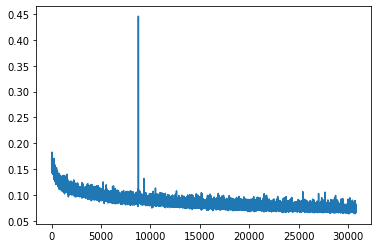

In [18]:
plt.plot(train_losses[500:])
plt.show()

In [ ]:
#model

In [ ]:
print(len(image_files))
image_files